In [301]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi

In [302]:
import matplotlib.pyplot as plt

In [303]:
import hvplot.pandas

In [304]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [305]:
# TODO
# Selecting the tickers can be a stand-alone function
# Set the ticker
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one month ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=52)

df = pd.DataFrame()

# Get historical data for AAPL
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=365,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)

df.head()

,AAPL,AMZN,GOOGL,NFLX
time,,,,
2019-01-16 00:00:00-05:00,154.9100,1681.9703,1088.210,350.7639
2019-01-17 00:00:00-05:00,155.5300,1691.3700,1098.150,353.8200
2019-01-18 00:00:00-05:00,156.5700,1693.2421,1105.400,338.9200
2019-01-22 00:00:00-05:00,152.9300,1628.3980,1074.540,324.5401
2019-01-23 00:00:00-05:00,153.6799,1636.5500,1082.815,321.5900


In [306]:
df.index = df.index.date

In [307]:
df.tail()

,AAPL,AMZN,GOOGL,NFLX
2020-06-22,358.93,2712.00,1450.44,468.08
2020-06-23,366.37,2764.42,1464.18,465.94
2020-06-24,360.06,2733.49,1432.17,457.65
2020-06-25,364.88,2756.16,1441.15,466.14
2020-06-26,353.69,2692.87,1362.14,443.39


In [308]:
aapl_df = df.loc[:, 'AAPL'].to_frame()
aapl_df.rename(columns={'AAPL': 'close'}, inplace=True)
aapl_df['lag_1_day'] = aapl_df['close'].shift()
aapl_df.dropna(inplace=True)

In [309]:
aapl_df.head()

,close,lag_1_day
2019-01-17,155.5300,154.9100
2019-01-18,156.5700,155.5300
2019-01-22,152.9300,156.5700
2019-01-23,153.6799,152.9300
2019-01-24,152.6300,153.6799


In [310]:
# X = aapl_df['AAPL'].copy()
# y = aapl_df['Shift']

In [311]:
aapl_df.close.hvplot(subplots=True, figsize=(12,8))

:Curve   [index]   (close)

In [312]:
aapl_df["return"] = aapl_df["close"].pct_change()
aapl_df.dropna(inplace=True)

In [313]:
aapl_df.head()

,close,lag_1_day,return
2019-01-18,156.5700,155.5300,0.006687
2019-01-22,152.9300,156.5700,-0.023248
2019-01-23,153.6799,152.9300,0.004904
2019-01-24,152.6300,153.6799,-0.006832
2019-01-25,157.5000,152.6300,0.031907


In [314]:
short_window = 20
long_window = 100

# Exponentially weighted moving average
aapl_df["short_window_ma"] = aapl_df["close"].ewm(halflife=short_window).mean()
aapl_df["long_window_ma"] = aapl_df["close"].ewm(halflife=long_window).mean()

# Expoentially weighted volatility
aapl_df["fast_vol"] = aapl_df["return"].ewm(halflife=short_window).std()
aapl_df["slow_vol"] = aapl_df["return"].ewm(halflife=long_window).std()

In [315]:
aapl_df.head()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2019-01-18,156.5700,155.5300,0.006687,156.570000,156.570000,NaN,NaN
2019-01-22,152.9300,156.5700,-0.023248,154.718465,154.743692,0.021167,0.021167
2019-01-23,153.6799,152.9300,0.004904,154.360212,154.386634,0.016776,0.016789
2019-01-24,152.6300,153.6799,-0.006832,153.904919,153.942899,0.013659,0.013763
2019-01-25,157.5000,152.6300,0.031907,154.674617,154.664216,0.020472,0.020283


In [316]:
aapl_df.dropna(inplace=True)

In [317]:
aapl_df.tail()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2020-06-22,358.93,349.55,0.026835,314.040927,271.812272,0.025539,0.027391
2020-06-23,366.37,358.93,0.020728,315.823455,272.524136,0.025259,0.027331
2020-06-24,360.06,366.37,-0.017223,317.330319,273.182729,0.025179,0.027285
2020-06-25,364.88,360.06,0.013387,318.950042,273.872206,0.024794,0.027197
2020-06-26,353.69,364.88,-0.030668,320.133416,274.471994,0.025240,0.027251


In [318]:
# Make copy of df for testing
aapl_df_copy = aapl_df.copy()

aapl_df.head()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2019-01-22,152.9300,156.5700,-0.023248,154.718465,154.743692,0.021167,0.021167
2019-01-23,153.6799,152.9300,0.004904,154.360212,154.386634,0.016776,0.016789
2019-01-24,152.6300,153.6799,-0.006832,153.904919,153.942899,0.013659,0.013763
2019-01-25,157.5000,152.6300,0.031907,154.674617,154.664216,0.020472,0.020283
2019-01-28,156.0878,157.5000,-0.008966,154.931015,154.905610,0.018857,0.018742


In [319]:
# X = aapl_df.close.values.reshape(-1, 1)
# X = aapl_df.close.values.reshape(-1, 1)
X = aapl_df.drop(columns=['lag_1_day'])
y = aapl_df.lag_1_day.values.reshape(-1, 1)

In [320]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.20)

In [321]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [322]:
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

In [323]:
from sklearn.svm import SVR

svr = SVR()

In [324]:
svr.fit(X_train_scaled, y_train)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [325]:
SVR_predictions = svr.predict(X_test_scaled)

SVR_predictions_df = pd.DataFrame({'predictions': SVR_predictions, 'actual': np.ravel(y_test)})

In [326]:
SVR_predictions_df.head()

,predictions,actual
0,231.446878,235.3200
1,277.619022,313.0300
2,191.744280,186.7900
3,191.759761,174.8800
4,266.597504,267.8999


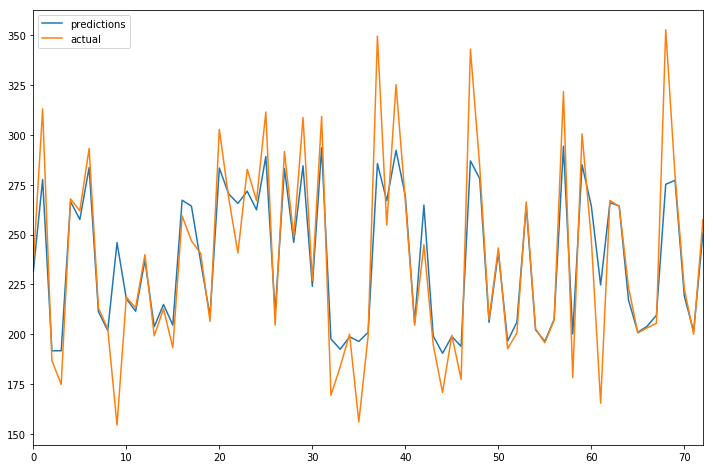

In [327]:
SVR_predictions_df.plot(figsize=(12,8))

In [328]:
from sklearn.metrics import mean_squared_error

SVR_MSE = mean_squared_error(y_test, SVR_predictions)

print(f"SVR MSE: {SVR_MSE}")

SVR MSE: 503.6349067259146


In [329]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=0)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


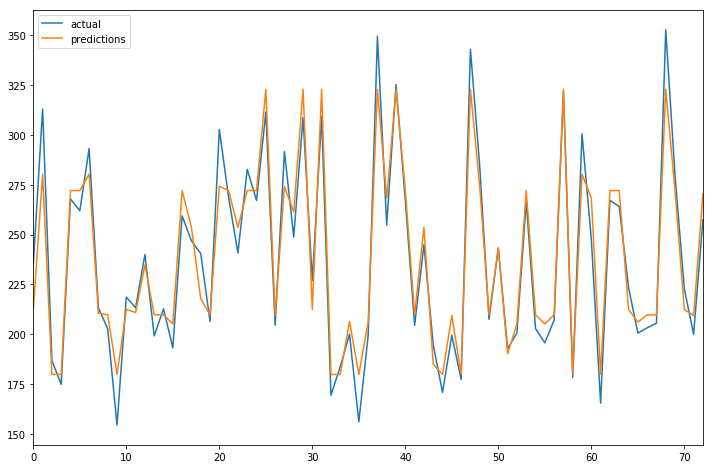

In [330]:
reg.fit(X_train_scaled, y_train)

RF_predictions = reg.predict(X_test_scaled)

aapl_RF_predictions_df = pd.DataFrame({'actual': np.ravel(y_test), 'predictions': RF_predictions})

aapl_RF_predictions_df.plot(figsize=(12,8))

In [331]:
RF_MSE = mean_squared_error(y_test, RF_predictions)

print(f"SVR MSE: {SVR_MSE}\nRF_MSE: {RF_MSE}")

SVR MSE: 503.6349067259146
RF_MSE: 157.9404791741538


In [332]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)

In [333]:
gbr.fit(X_train_scaled, y_train)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

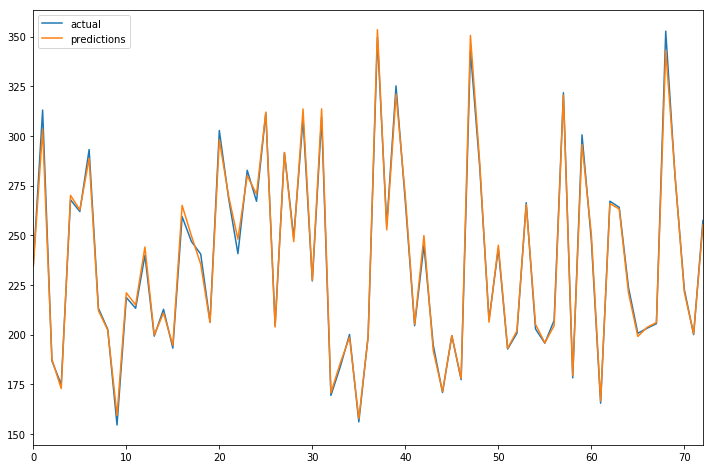

In [334]:
GBR_predictions = gbr.predict(X_test_scaled)

aapl_GBR_predictions_df = pd.DataFrame({'actual': np.ravel(y_test), 'predictions': GBR_predictions})

aapl_GBR_predictions_df.plot(figsize=(12,8))

In [335]:
GBR_MSE = mean_squared_error(y_test, GBR_predictions)

print(f"GBR MSE: {GBR_MSE}\nRF_MSE: {RF_MSE}\nSVR_MSE: {SVR_MSE}")

GBR MSE: 9.767603116529894
RF_MSE: 157.9404791741538
SVR_MSE: 503.6349067259146


In [337]:
# from sklearn.model_selection import grid_search

In [338]:
amzn_df = df.loc[:, 'AMZN'].to_frame()
amzn_df.rename(columns={'AMZN': 'close'}, inplace=True)
amzn_df['lag_1_day'] = amzn_df['close'].shift()
amzn_df.dropna(inplace=True)

In [339]:
amzn_df.head()

,close,lag_1_day
2019-01-17,1691.3700,1681.9703
2019-01-18,1693.2421,1691.3700
2019-01-22,1628.3980,1693.2421
2019-01-23,1636.5500,1628.3980
2019-01-24,1654.9700,1636.5500


In [340]:
amzn_df["return"] = amzn_df["close"].pct_change()
amzn_df.dropna(inplace=True)

In [341]:
amzn_df.head()

,close,lag_1_day,return
2019-01-18,1693.2421,1691.3700,0.001107
2019-01-22,1628.3980,1693.2421,-0.038296
2019-01-23,1636.5500,1628.3980,0.005006
2019-01-24,1654.9700,1636.5500,0.011255
2019-01-25,1668.6000,1654.9700,0.008236


In [342]:
short_window = 20
long_window = 100

# Exponentially weighted moving average
amzn_df["short_window_ma"] = amzn_df["close"].ewm(halflife=short_window).mean()
amzn_df["long_window_ma"] = amzn_df["close"].ewm(halflife=long_window).mean()

# Expoentially weighted volatility
amzn_df["fast_vol"] = amzn_df["return"].ewm(halflife=short_window).std()
amzn_df["slow_vol"] = amzn_df["return"].ewm(halflife=long_window).std()

In [343]:
amzn_df.dropna(inplace=True)

In [344]:
X2 = amzn_df.drop(columns=['lag_1_day'])
y2 = amzn_df.lag_1_day.values.reshape(-1, 1)

In [345]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0, test_size=0.20)

In [346]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [347]:
X_train_scaled2, X_test_scaled2 = scaler.fit_transform(X_train2), scaler.transform(X_test2)

In [348]:
gbr2 = GradientBoostingRegressor(random_state=0)

gbr2.fit(X_train_scaled2, y_train2)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

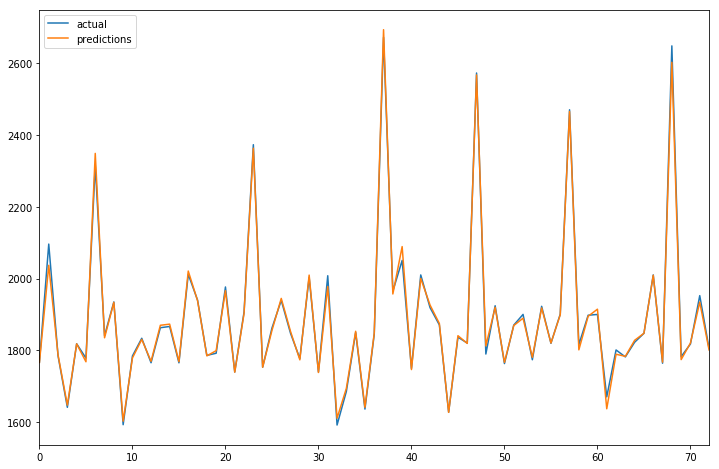

In [349]:
GBR_predictions2 = gbr2.predict(X_test_scaled2)

GBR_predictions2_df = pd.DataFrame({'actual': np.ravel(y_test2), 'predictions': GBR_predictions2})

GBR_predictions2_df.plot(figsize=(12,8))

In [353]:
from sklearn.metrics import mean_squared_error

GBR2_MSE = mean_squared_error(y_test2, GBR_predictions2)

# print(f"GBR1 MSE: {GBR_MSE}\nRF_MSE: {RF_MSE}\nSVR_MSE: {SVR_MSE}\nGBR2 MSE: {GBR2_MSE}")
print(f"GBR2_MSE: {GBR2_MSE}")

GBR2_MSE: 193.28986996643528
